## makemore: becoming a backprop ninja

In [ ]:
# there no change change in the first several cells from last lecture

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words=open('C:\\Users\\Administrator\\Desktop\\NN\\Python\\name.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes 
# subtract max for numerical stability,avoid exp() from exploding because the largst value will be zero, but this won't affect probs,
#so dlogit_maxes should just be zero. in fact, even if we calculate this gradient, it is very small values
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3230, grad_fn=<NegBackward0>)

In [25]:
dlogit_maxes

tensor([[-5.1223e-09],
        [-4.6566e-10],
        [-1.8626e-09],
        [-4.6566e-09],
        [ 6.0536e-09],
        [-2.3283e-10],
        [-4.6566e-10],
        [ 2.3283e-09],
        [-0.0000e+00],
        [ 1.6298e-09],
        [-4.6566e-10],
        [-1.1642e-09],
        [ 1.1642e-09],
        [-3.0268e-09],
        [ 3.2596e-09],
        [ 1.8626e-09],
        [ 3.7253e-09],
        [ 2.7940e-09],
        [ 1.6298e-09],
        [ 6.0536e-09],
        [-1.8626e-09],
        [-6.0536e-09],
        [ 1.6298e-09],
        [ 6.0536e-09],
        [ 1.8626e-09],
        [-4.8894e-09],
        [-2.3283e-09],
        [-5.5879e-09],
        [ 4.6566e-10],
        [ 1.6298e-09],
        [ 2.7940e-09],
        [-2.3283e-10]], grad_fn=<NegBackward0>)

In [67]:
 bngain.shape
(dhpreact*bnbias).shape
hprebn.shape,W1.shape
emb.shape

torch.Size([32, 3, 10])

In [32]:
logits.max(1)#.indices

torch.return_types.max(
values=tensor([1.1287, 0.8542, 1.1126, 0.5251, 1.7493, 0.9382, 0.7013, 1.4185, 1.0686,
        1.0843, 1.8014, 2.0040, 1.0607, 0.8043, 0.5447, 0.7522, 0.8604, 0.8743,
        1.0607, 0.7406, 0.7334, 0.9954, 1.0607, 1.1768, 1.4474, 0.9681, 1.1986,
        0.9328, 0.9361, 0.7185, 1.0289, 0.7130], grad_fn=<MaxBackward0>),
indices=tensor([ 1,  2, 19, 15, 15, 25, 16,  3, 19,  8, 15,  3, 22, 18, 17,  5,  2,  1,
        22, 19, 15, 19, 22, 22, 23,  5, 22, 20, 24,  6, 24, 13]))

requires_grad means two things:

That we should compute gradients for this variable and functions of this variable

On a "leaf" variable, it means we should store the gradient to the "grad" attribute

The retain_grad() functions is used to signify that we should store the gradient on non-"leaf" variables to the "grad" attribute.

In [69]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
dlogprobs=torch.zeros_like(logprobs)
dlogprobs[range(n),Yb]=-1.0/n
cmp('logprobs', dlogprobs, logprobs)

dprobs=(1/probs) * dlogprobs  #*表示对应元素相乘  #boost the gradients of falsely assigned probabilities
cmp('probs', dprobs, probs)

dcounts_sum_inv=(counts*dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum=-counts_sum**-2 * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

dnorm_logits=counts*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

dlogit_maxes = -dnorm_logits.sum(1,keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits=dnorm_logits.clone()  #!!!这里要注意，直接写y=x修改y的值同时x的值也会被修改，这种复制其实复制的是地址
mask=torch.zeros_like(logits)
mask[range(len(logits)),logits.argmax(1)]=1
dlogits+=dlogit_maxes*mask
#也可以dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

dh = dlogits @ W2.T
cmp('h', dh, h)

dW2=h.T @ dlogits
cmp('W2', dW2, W2)

db2=dlogits.sum(0)
cmp('b2', db2, b2)

dhpreact=(1-h**2)*dh
cmp('hpreact', dhpreact, hpreact)

dbngain=(dhpreact*bnraw).sum(0,keepdim=True)
cmp('bngain', dbngain, bngain)

dbnbias=dhpreact.sum(0,keepdim=True)
cmp('bnbias', dbnbias, bnbias)

dbnraw=dhpreact*bngain
cmp('bnraw', dbnraw, bnraw)

dbnvar_inv=(dbnraw*bndiff).sum(0,keepdim=True) 
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar=-0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

dbndiff2=(1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff=dbndiff2 * (2*bndiff)
dbndiff+=dbnraw*bnvar_inv
cmp('bndiff', dbndiff, bndiff)

dbnmeani=-dbndiff.sum(0,keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn=dbndiff.clone()
dhprebn+=1.0/n * (torch.ones_like(hprebn)*dbnmeani)
cmp('hprebn', dhprebn, hprebn)

dembcat=dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1=embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1=dhprebn.sum(0)
cmp('b1', db1, b1)

demb=dembcat.view(emb.shape)  #!可以这么写哦
cmp('emb', demb, emb)

dC=torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]   ##this is super clever! 
#and note this, 如果一个字母从来在training set里面出现过，则意味着对应embedding参数/gradient不会被更新，当test set出现该字母时的generalization effect不好
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [ ]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

In [70]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits,1)  #对行进行softmax
dlogits[range(n),Yb] -=1
dlogits /= n
# -----------------

#cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

intuitive explanation of cross entrophy loss:

i不等于j: dlogits=p_i

i等于j: dlogits=p_i-1

对于每一个样本，dlogits的和是0，在j位置上的probability应该要越接近1越好，其他位置上的要越接近0越好。j位置上的probability与1的距离越大，他就会被越大的gradient的pull up，其他位置则会被pull down

In [71]:
F.softmax(logits, 1)[0]

tensor([0.0618, 0.0996, 0.0188, 0.0490, 0.0170, 0.0780, 0.0234, 0.0355, 0.0181,
        0.0337, 0.0378, 0.0416, 0.0394, 0.0273, 0.0301, 0.0139, 0.0084, 0.0206,
        0.0157, 0.0538, 0.0506, 0.0227, 0.0267, 0.0721, 0.0548, 0.0276, 0.0221],
       grad_fn=<SelectBackward0>)

In [72]:
dlogits[0] * n   #与上面一样，除了j位置-1

tensor([ 0.0618,  0.0996,  0.0188,  0.0490,  0.0170,  0.0780,  0.0234,  0.0355,
        -0.9819,  0.0337,  0.0378,  0.0416,  0.0394,  0.0273,  0.0301,  0.0139,
         0.0084,  0.0206,  0.0157,  0.0538,  0.0506,  0.0227,  0.0267,  0.0721,
         0.0548,  0.0276,  0.0221], grad_fn=<MulBackward0>)

In [73]:
dlogits[0].sum()   #0

tensor(3.2596e-09, grad_fn=<SumBackward0>)

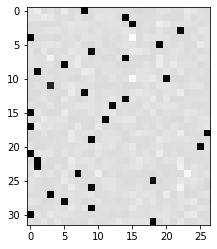

In [74]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [75]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

In [82]:
(bngain*bnvar_inv).shape,dhpreact.shape,(dhpreact - dhpreact.sum(0)).shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))